In [16]:
import numpy as np
from scipy import stats
import random
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import os
import sys
import glob
import time

import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from IPython.display import Image
import imageio
import pandas as pd

path_dir = os.getcwd()
from config.utils import *

## Initialiser les données

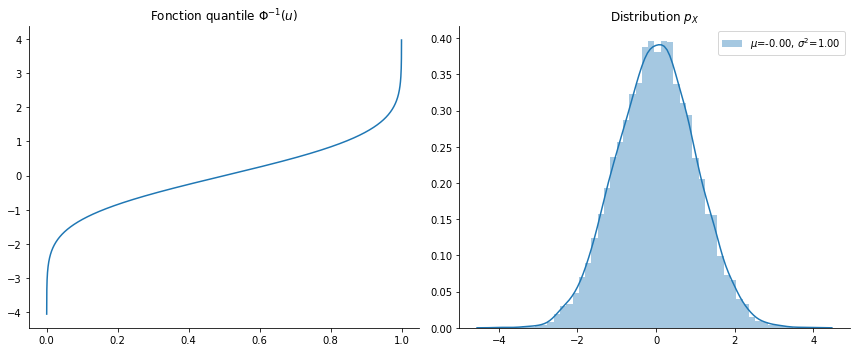

In [17]:
np.random.seed(1234)
N_DATA = 10000
DATA_DIM = 1

uniform = np.random.uniform(size=(N_DATA, DATA_DIM))

dataset_train = stats.norm.ppf(uniform).astype(np.float32)

# visualization
viz_gaussian_train(uniform, dataset_train)

## Implémentation

### Generator

In [18]:
def build_generator(latent_dim, n_neurons, data_dim=DATA_DIM):

    model = tf.keras.Sequential(name="Generator")
    model.add(layers.Dense(n_neurons, input_shape=(latent_dim,), bias_initializer="glorot_normal"))
    

    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Dense(data_dim, bias_initializer="glorot_normal"))
    return model

G_test = build_generator(latent_dim=1, n_neurons=10)
G_test.summary()  

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 10)                20        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


### Discriminator

In [19]:
def build_discriminator(n_neurons, data_dim=DATA_DIM):

    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Dense(n_neurons, input_shape=(DATA_DIM,), bias_initializer="glorot_normal", 
                           kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    

    model.add(layers.Dense(n_neurons, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    model.add(layers.Dense(units = 1, bias_initializer="glorot_normal", kernel_initializer="glorot_normal"))

    return model

D_test = build_discriminator(n_neurons=10)
D_test.summary() 

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                20        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                110       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [20]:
def discriminator_loss(real_output, fake_output): 

    return -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(real_output) ) + tf.math.log(1. - tf.nn.sigmoid(fake_output) ))
  
def generator_loss(fake_output):

    return -tf.reduce_mean(tf.math.log(tf.nn.sigmoid(fake_output) ))

### Definir la fonction d'entraînement et déterminer les paramètres

<font color ="red"> **Relancez toujours cette cellule avant de lancer la boucle d'entraînement !**

In [21]:
tf.random.set_seed(1234)
np.random.seed(1234)
counter_seed = 0

# Choix des paramètres d'entrainement:
BATCH_SIZE = 50
LATENT_DIM = 1
EPOCHS =  10
NEURONS_G = 100
NEURONS_D = 100
k = 3

# Construction du GAN
generator = build_generator(LATENT_DIM, NEURONS_G)
discriminator = build_discriminator(NEURONS_D)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# pour l'affichage
list_loss_G_train=[]
list_loss_D_train=[]

# ===========================================================================
# ===========================================================================
@tf.function
def train_step(data_batch, noise_dim):
    """
    Calcul du gradient et mise à jour des paramètres à chaque itération

    Parameters
    ----------
    data_batch: arr
        Batch de données (x_1, ..., x_m)
    noise_dim: int
        Dimension de la variable latente
    """
    
    tf.random.set_seed(counter_seed)  # actualisation de la seed pour chaque train_step 
    batch_size = data_batch.shape[0]
    
    # Entrainement du Discriminateur
    noise = tf.random.uniform([batch_size, noise_dim])  # z = (z_1, .., z_m)
    with tf.GradientTape() as disc_tape:
        generated_data = generator(noise)  # G(z)  
        real_output = discriminator(data_batch)  # D(x)
        fake_output = discriminator(generated_data)  # D(G(z))

        disc_loss = discriminator_loss(real_output, fake_output)  # calcul de la loss du discriminateur
    
    # calcul du gradient
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # mise à jour des paramètres
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        
    # Entrainement du Générateur
    #############
    # sur la base du discriminateur
    #############
    noise = tf.random.uniform([batch_size, noise_dim]) # z = (z_1, .., z_m)
    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise)  # G(z) 
        fake_output = discriminator(generated_data)  # D(G(z))
        
        gen_loss = generator_loss(fake_output)  # calcul de la loss du générateur
    
    # calcul du gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # mise à jour des paramètres
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return

def evaluate(data, noise_test):

    
    generated_data = generator(noise_test)
    real_output = discriminator(data)
    fake_output = discriminator(generated_data)
    
    loss_D = discriminator_loss(real_output, fake_output)
    loss_G = generator_loss(fake_output)

    return loss_G.numpy(), loss_D.numpy()

In [22]:
##  to examine the impact of k
def train_step_k(sub_data_batches, noise_dim, batch_size = BATCH_SIZE, k = k):
    """
    Calcul du gradient et mise à jour des paramètres à chaque itération

    Parameters
    ----------
    data_batch: arr
        Batch de données (x_1, ..., x_m)
    noise_dim: int
        Dimension de la variable latente
    """
    
    tf.random.set_seed(counter_seed)  # actualisation de la seed pour chaque train_step 
    
    # Entrainement du Discriminateur
    for i in range(k):
        data_batch = tf.convert_to_tensor(sub_data_batches[i],np.float32)  # x = (x_1, .., x_m)
        noise = tf.random.uniform([batch_size, noise_dim])  # z = (z_1, .., z_m)
        with tf.GradientTape() as disc_tape:
            generated_data = generator(noise)  # G(z)  
            real_output = discriminator(data_batch)  # D(x)
            fake_output = discriminator(generated_data)  # D(G(z))

            disc_loss = discriminator_loss(real_output, fake_output)  # calcul de la loss du discriminateur

        # calcul du gradient
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # mise à jour des paramètres
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        
    # Entrainement du Générateur
    #############

    # sur la base du discriminateur
    #############
    noise = tf.random.uniform([batch_size, noise_dim]) # z = (z_1, .., z_m)
    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise)  # G(z) 
        fake_output = discriminator(generated_data)  # D(G(z))
        
        gen_loss = generator_loss(fake_output)  # calcul de la loss du générateur
    
    # calcul du gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # mise à jour des paramètres
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return

**Visualisation avant entraînement**

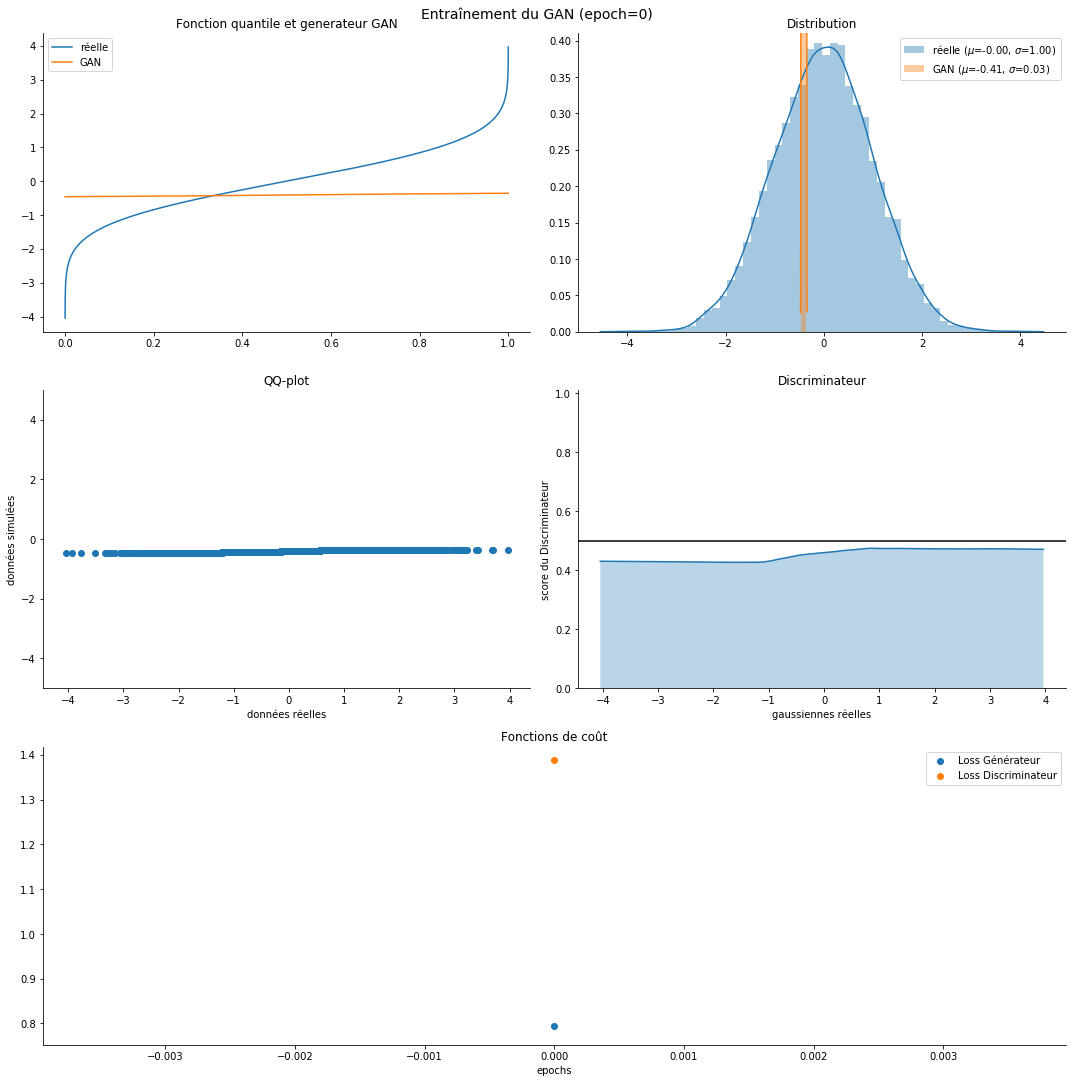

In [23]:
np.random.seed(1234)
noise_test = np.random.uniform(size=(N_DATA, LATENT_DIM))

# évaluation sur toutes les données avec un bruit test fixe
loss_G, loss_D = evaluate(dataset_train, noise_test)  
list_loss_G_train.append(loss_G)
list_loss_D_train.append(loss_D)

# Une autre fonction importée du fichier utils.py
viz_gaussian_gan(noise_test, dataset_train, generator, discriminator, list_loss_G_train, list_loss_D_train, epoch=0)

plt.savefig(os.path.join(path_dir, "imgs", "gaussian", "image_gaussian_N{}-Ldim{}-bs{}_at_epoch_{}.png".format(
    N_DATA, LATENT_DIM, BATCH_SIZE, 0)))

**Entraînement**



In [24]:
data_batches = tf.data.Dataset.from_tensor_slices(dataset_train).batch(BATCH_SIZE)
np_data_batches = np.stack(list(data_batches))

Epoch 10 (1.28 sec): Loss Generateur=0.818, Loss Discriminateur=1.220


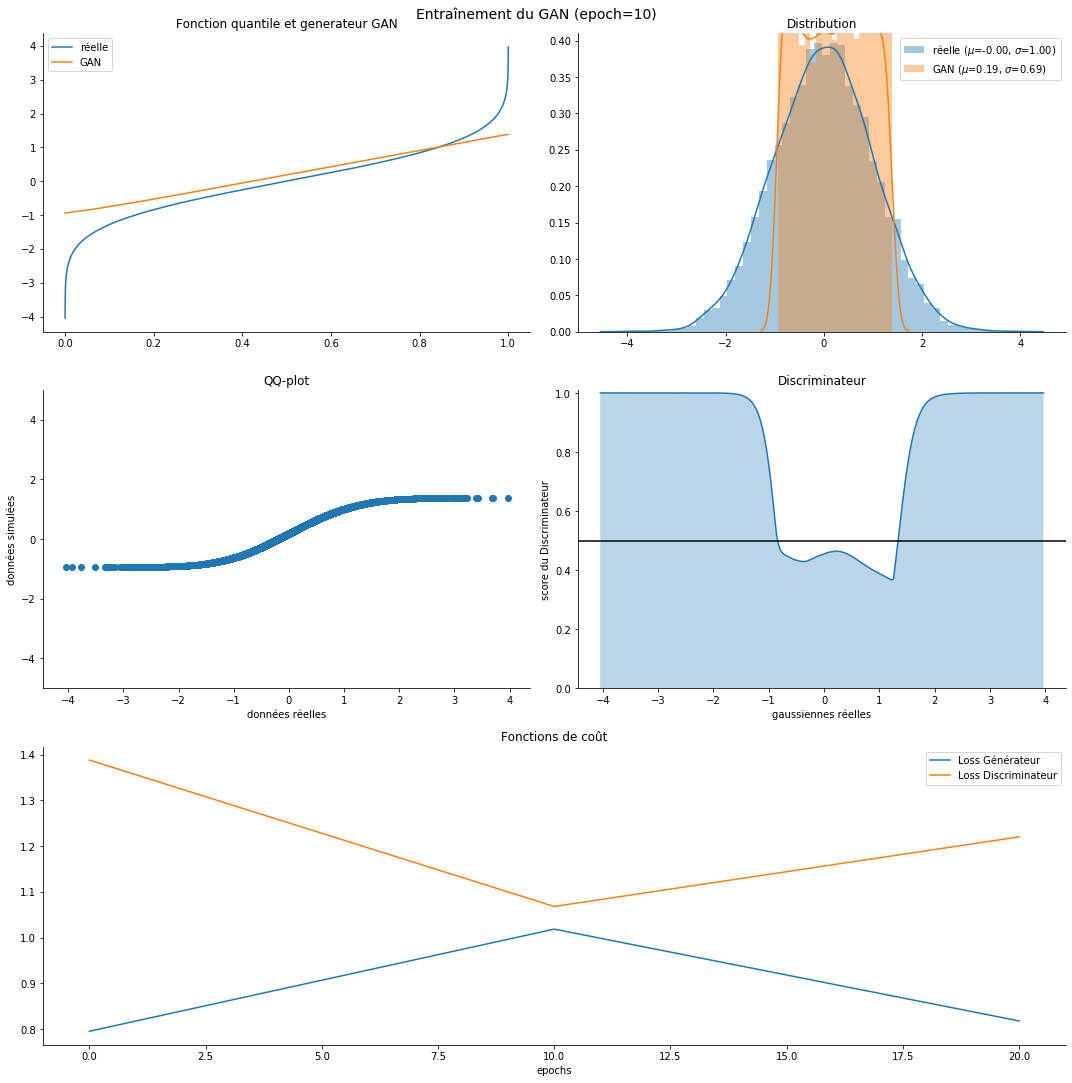

Fin de l'entraînement.


In [26]:
# Boucle d'entraînement:
print("Début de l'entraînement ...")

# division des données en batch de taille BATCH_SIZE
data_batches = tf.data.Dataset.from_tensor_slices(dataset_train).batch(BATCH_SIZE)
np_data_batches = np.stack(list(data_batches))

for epoch in range(1, EPOCHS+1):
    print("epoch = {}".format(epoch))
    start_time= time.time()
    counter_seed+=1
    

    
    for i in range(int(len(data_batches)/k)):

        counter_seed += 1
        train_step_k(np_data_batches[(k*i):(k*i+k)], LATENT_DIM)
    
    if (epoch) % 10 == 0:    
        # évaluation à epoch modulo 10 sur toutes les données avec un bruit test fixe
        loss_G, loss_D = evaluate(dataset_train, noise_test)  
        list_loss_G_train.append(loss_G)
        list_loss_D_train.append(loss_D)
        
        time_epoch = time.time() - start_time
        display.clear_output(wait=True)
        print("Epoch {} ({:.2f} sec): Loss Generateur={:.3f}, Loss Discriminateur={:.3f}".format(\
            epoch, time_epoch, loss_G, loss_D))

        viz_gaussian_gan(noise_test, dataset_train, generator, discriminator, 
                         list_loss_G_train, list_loss_D_train, epoch)

         #sauvegarde image
        plt.savefig(os.path.join(path_dir, "imgs", "gaussian", "image_gaussian_N{}-Ldim{}-bs{}_at_epoch_{}_on_{}.png"
                                 .format(N_DATA, LATENT_DIM, BATCH_SIZE, epoch, EPOCHS)))
        plt.show()
        
    if (epoch) % (EPOCHS/10) == 0:
        # sauvegarde les modèles 10 fois durant l'entraînement
        generator.save(os.path.join(path_dir, "models", "gaussian", "generator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, EPOCHS, BATCH_SIZE)))
            
        discriminator.save(os.path.join(path_dir,"models", "gaussian", "discriminator-N{}-Ldim{}-epoch{}-bs{}.h5".format(
            N_DATA, LATENT_DIM, EPOCHS, BATCH_SIZE)))
        
save_GIF(path_dir, N_DATA, LATENT_DIM, BATCH_SIZE, EPOCHS)   
print("Fin de l'entraînement.")

In [27]:
## perte global de GAN
def loss_GAN(data, noise, generator, discriminator):

    
    terme1 = tf.reduce_mean(tf.math.log(tf.nn.sigmoid(discriminator(data))))
    terme2 = tf.reduce_mean(tf.math.log(1. - tf.nn.sigmoid(discriminator(generator(noise_test)))))
    return terme1 + terme2

tf.random.set_seed(1234)
np.random.seed(1234)

LATENT_DIM = 1
noise_test = np.random.uniform(size=(N_DATA, LATENT_DIM))

min_global_pred = loss_GAN(dataset_train, noise_test, generator, discriminator)  # loss après entraînement

print("Dimension latente: {}".format(LATENT_DIM))
print("-"*20)
print("Minimum global du modèle après entraînement = {:.6f}".format(min_global_pred.numpy()))
print("Minimum global théorique = {:.6f}".format(-np.log(4)))

Dimension latente: 1
--------------------
Minimum global du modèle après entraînement = -1.220115
Minimum global théorique = -1.386294
